In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seawater as sw #import gsw

In [1]:
# location of input data
data_path = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'INALT20.L46-KFS119' 
data_resolution = '1d'

# location of mask data
mask_path = data_path
mesh_mask_filename = '1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc'

# names of files to load
fname_T = f'1_{experiment_name}_{data_resolution}_2009*_grid_T_iMirabilis.nc'

#ROMS
ROMS_path = f'/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/roms_avg*_2009_datetime.nc'
ROMSchild_path = f'/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/roms_avg*_2009_datetime.nc.1'

depthpath_ROMS = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/sigma2depth_parent.nc'
depthpath_ROMSchild = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/sigma2depth_child.nc'

In [3]:
from dask.distributed import Client

In [4]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

2023-09-20 17:07:21,724 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-yu3g7dmm', purging
2023-09-20 17:07:21,725 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-nk_uipfr', purging
2023-09-20 17:07:21,726 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-cxti2etp', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.15:8787/status,
Dashboard: http://134.245.3.15:8787/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.15:33227,Workers: 4
Dashboard: http://134.245.3.15:8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.3.15:35711,Total threads: 2
Dashboard: http://134.245.3.15:46005/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.15:40599,


In [3]:
T = xr.open_mfdataset(data_path+experiment_name+'/'+fname_T)
T_ROMS = xr.open_mfdataset(ROMS_path)
T_ROMSchild = xr.open_mfdataset(ROMSchild_path)

depth_ROMS = xr.open_dataset(depthpath_ROMS)
depth_ROMSchild = xr.open_dataset(depthpath_ROMSchild)

In [4]:
# sigma levels to meters
Ewing_ROMS = depth_ROMS.hs.where((depth_ROMS.lat_rho < -23.1) & (depth_ROMS.lat_rho > -23.35) & (depth_ROMS.lon_rho > 8.15) & (depth_ROMS.lon_rho < 8.5), drop = True)
Ewing_ROMSchild = depth_ROMSchild.hs.where((depth_ROMSchild.lat_rho < -23.1) & (depth_ROMSchild.lat_rho > -23.35) & (depth_ROMSchild.lon_rho > 8.15) & (depth_ROMSchild.lon_rho < 8.5), drop = True)

# Density

In [5]:
%%time

#limit to area around Ewing (if only one location is chosen, the calculation in wayyyyy faster)
sliced = T.where((T.nav_lat < -23.1) & (T.nav_lat > -23.35) & (T.nav_lon > 8.15) & (T.nav_lon < 8.5) & (T.deptht<200), drop = True).compute()
sliced_ROMS = T_ROMS.where((T_ROMS.lat_rho < -23.1) & (T_ROMS.lat_rho > -23.35) & (T_ROMS.lon_rho > 8.15) & (T_ROMS.lon_rho < 8.5), drop = True).compute()
sliced_ROMSchild = T_ROMSchild.where((T_ROMSchild.lat_rho < -23.1) & (T_ROMSchild.lat_rho > -23.35) & (T_ROMSchild.lon_rho > 8.15) & (T_ROMSchild.lon_rho < 8.5), drop = True).compute()

/opt/conda/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


CPU times: user 2min 47s, sys: 1min 19s, total: 4min 6s
Wall time: 3min 50s


In [7]:
# expand depth levels for INALT
expand_depth = xr.DataArray(np.zeros((14,5,6)))
expand_depth[:,:,:]=sliced.deptht.values[:,np.newaxis,np.newaxis]

In [36]:
%%time

# EOS80 density https://pythonhosted.org/seawater/eos80.html

sigma = xr.DataArray(sw.pden(sliced.vosaline,
                             sliced.votemper,
                             expand_depth,
                            )-1000, dims=('time_counter', 'deptht','lon','lat')).compute()
sigma = sigma.assign_coords(time_counter=sliced.time_counter, deptht=sliced.deptht.to_numpy())

sigma_ROMS = xr.DataArray(sw.pden(sliced_ROMS.salt,
                             sliced_ROMS.temp,
                             Ewing_ROMS,
                            )-1000, dims=('time', 's_rho','lat','lon')).compute()
sigma_ROMS = sigma_ROMS.assign_coords(time=sliced_ROMS.time,s_rho=sliced_ROMS.s_rho)

sigma_ROMSchild = xr.DataArray(sw.pden(sliced_ROMSchild.salt,
                             sliced_ROMSchild.temp,
                             Ewing_ROMSchild,
                            )-1000, dims=('time', 's_rho','lat','lon')).compute()
sigma_ROMSchild = sigma_ROMSchild.assign_coords(time=sliced_ROMSchild.time, s_rho=sliced_ROMSchild.s_rho)

CPU times: user 6.8 s, sys: 2.98 s, total: 9.78 s
Wall time: 9.82 s


In [39]:
%%time

# determine mixed layer depths...
MLD_INALT_s, MLD_ROMS_s, MLD_ROMSchild_s = [],[],[]

for i in np.arange(1): #...for each day
    MLD_INALT_step, MLD_ROMS_step, MLD_ROMSchild_step = [],[],[] #empty lists for daily values
    for j in np.arange(len(sigma.lon)): #...each lon...
        for k in np.arange(len(sigma.lat)): #...and each lat around Ewing
            sigma.isel(time_counter=i, lon=j, lat=k).plot() #plot density
            threshold1_s = sigma.isel(time_counter=i, lon=j, lat=k).sel(deptht = 10, method = 'nearest')+.01 #get density threshold (10m density +.1 dsigma)
            lines = plt.gca().get_lines() #get lines of plot
            x_data1 = lines[0].get_xdata() #...
            y_data1 = lines[0].get_ydata() #...
            intersec_INALT = None
            for l in range(len(x_data1)): #determine intersec with threshold
                if y_data1[l] > threshold1_s and intersec_INALT is None:
                    intersec_INALT = x_data1[l]
            MLD_INALT_step.append(intersec_INALT) #append MLD for each location around Ewing at a day
            plt.close()
    MLD_INALT_s.append(np.mean(MLD_INALT_step)) #append mean for each day --> list with a value for each day
    
    #same for ROMS...
    for j in np.arange(len(sigma_ROMS.lon)):
        for k in np.arange(len(sigma_ROMS.lat)):
            sigma_ROMS.isel(time=i, lon=j, lat=k).assign_coords(s_rho=Ewing_ROMS.isel(lon_rho=j, lat_rho=k).to_numpy()).plot()
            threshold2_s = sigma_ROMS.isel(time=i, lon=j, lat=k).assign_coords(
                s_rho=Ewing_ROMS.isel(lon_rho=j, lat_rho=k).to_numpy()).sel(s_rho = 10, method= 'nearest')+.01
            lines = plt.gca().get_lines()
            x_data2 = np.flip(lines[0].get_xdata())
            y_data2 = np.flip(lines[0].get_ydata())
            intersec_ROMS = None
            for l in range(len(x_data2)):
                if y_data2[l] > threshold2_s and intersec_ROMS is None:
                    intersec_ROMS = x_data2[l]
            MLD_ROMS_step.append(intersec_ROMS)
            plt.close()
    MLD_ROMS_s.append(np.mean(MLD_ROMS_step))
    
    #same for ROMS child...
    for j in np.arange(len(sigma_ROMSchild.lon)):
        for k in np.arange(len(sigma_ROMSchild.lat)):
            sigma_ROMSchild.isel(time=i, lon=j, lat=k).assign_coords(s_rho=Ewing_ROMSchild.isel(lon_rho=j, lat_rho=k).to_numpy()).plot()
            threshold3_s = sigma_ROMSchild.isel(time=i, lon=j, lat=k).assign_coords(
                s_rho=Ewing_ROMSchild.isel(lon_rho=j, lat_rho=k).to_numpy()).sel(s_rho = 10, method= 'nearest')+.01
            lines = plt.gca().get_lines()
            x_data3 = np.flip(lines[0].get_xdata())
            y_data3 = np.flip(lines[0].get_ydata())
            intersec_ROMSchild = None
            for l in range(len(x_data3)):
                if y_data3[l] > threshold3_s and intersec_ROMSchild is None:
                    intersec_ROMSchild = x_data3[l]
            MLD_ROMSchild_step.append(intersec_ROMSchild)
            plt.close()
    MLD_ROMSchild_s.append(np.mean(MLD_ROMSchild_step))

CPU times: user 1min 27s, sys: 3.11 s, total: 1min 30s
Wall time: 1min 30s


In [40]:
data = {'INALT': MLD_INALT_s,'ROMS': MLD_ROMS_s, 'ROMSchild': MLD_ROMSchild_s}
MLD_s = pd.DataFrame(data,index=pd.date_range(start='2009-01-01', end='2009-12-31'))

In [ ]:
MLD_s.to_csv(f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/retention/MLD2009_s001_EOS80.csv')

NameError: name 'monthly_means_s' is not defined

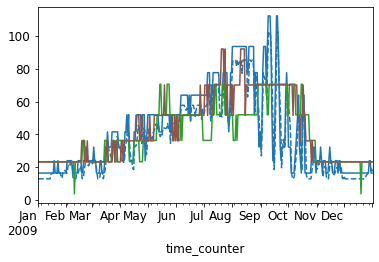

In [20]:
#monthly_means_s = MLD_s.resample('M').mean()
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Arial'

MLD_s['INALT'].plot(color='tab:blue')
#MLD_Franziska_sliced.squeeze().to_pandas().plot(color='tab:blue',linestyle='--') #.resample(time_counter='1M').mean()
MLD_s['ROMS'].plot(color='tab:green')
MLD_s['ROMSchild'].plot(color='tab:brown')
plt.xticks(monthly_means_s.index,['Jan\n2009','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('MLD [m]')
plt.ylim([0,110])
plt.gca().invert_yaxis();